# Annotation Validator
## Provides a visual validation of the Annotations on a specific image

In [1]:
"""
23/03/21 09:44
Developed by Miles Danswan
"""

'\n23/03/21 09:44\nDeveloped by Miles Danswan\n'

In [2]:
import os # traversing the native filesystem
import numpy as np # specific array operations
import json as js # parsing the json annotation files
import tkinter.filedialog as fd # open file dialog (retrieiving json files)
import matplotlib.pyplot as plt # working with skimage
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg # creating tkinter canvas from MPL figure
from skimage import io # processing images
from tkinter import * # displaying a native window
from tkinter import ttk

In [3]:
"""
CONSTANTS
"""
WINDOW_BG = "black"

REGION_TYPES = ["circular", "rect", "polygon"]
REGION_TYPE_FILL_COLOURS = {REGION_TYPES[0] : "steelblue",
                            REGION_TYPES[1] : "orangered",
                            REGION_TYPES[2] : "red"}
REGION_BORDER_WIDTH = 2
REGION_ALPHA = 0.4

REGION_LABEL_FONT_SIZE = 10
REGION_LABEL_DISP = 5
REGION_LABEL_WEIGHT = "bold"
REGION_LABEL_FG = "white"
REGION_LABEL_BBOX = dict(facecolor="black", edgecolor="blue", alpha=0.5, linewidth=2)

SIDEPANEL_BG = "white"

POLY_REGION_LABEL = "POLYGON"

RECT_REGION_LABEL = "RECT"

In [4]:
"""
Creates an OpenFileName dialog for Retrieving a Filename
"""
def get_filename(root):
    return fd.askopenfilename(parent=root,filetypes=[("Annotation Files", "*.json"), ("All", "*.*")])

In [5]:
"""
Creates an OpenDirectory dialog for Retrieving a Directory Name
"""
def get_dirname(root):
    return fd.askdirectory(parent=root)

In [6]:
"""
Retrieves a list of image names from the top level directory of the provided path
"""
def get_dir_img_list(root):
    
    dirpath = get_dirname(root)
    
    img_list = []
    
    for (dirpath, subdirs, filenames) in os.walk(dirpath):
        for fn in filenames:
            if (fn.endswith(".png") or fn.endswith(".jpg") or fn.endswith(".jpeg")):
                img_list.append(fn)
                                
    return (dirpath, img_list)

In [7]:
"""
Gets a Json Annotation file and attempts to find the corresponding Image file
"""
def get_annotation_set(root):
    
    json_filepath = None
    img_filepath = None
    
    # retrieve and split the filename of a json file
    fn = get_filename(root)
    json_filepath = fn
    path = os.path.split(fn)
    directory = path[0]
    filename = os.path.splitext(path[1])[0]
    
    # attempt to find the corresponding image file (recognised img files: png, jpg, jpeg)
    for fn in os.listdir(directory):
        if ((filename in fn) and (fn.endswith(".png") or fn.endswith(".jpg") or fn.endswith(".jpeg"))):
            img_filepath = directory + "/" + fn
            break
            
    return (json_filepath, img_filepath)

In [8]:
"""
Creates a basic TK Window with the provided name and width x height
"""
def create_window(name, w_x_h):
    
    main = Tk()
    main.title(name)
    main.geometry(w_x_h)
    main["bg"] = WINDOW_BG;
    
    return main

In [9]:
"""
Gets the Polygon Region Points and Rectangle Region Points from the provided Json file

TODO: Divide the following function into load_json_file and get_region_points
"""
def load_json_file(filepath):
    
    poly_region_points = []
    rect_region_points = []
        
    with open(filepath) as json:
        data = js.load(json)
        image_id = data["_via_image_id_list"][0]
        anno_data = data["_via_img_metadata"][image_id]
        for region in anno_data["regions"]:
            reg_shape_attr = region["shape_attributes"]
            if (reg_shape_attr["name"] == REGION_TYPES[2]):
                region_point = []
                for i in range(len(reg_shape_attr["all_points_x"])):
                    region_point.append((reg_shape_attr["all_points_x"][i], reg_shape_attr["all_points_y"][i]))
                poly_region_points.append(region_point)
            elif (reg_shape_attr["name"] == REGION_TYPES[1]):
                rect_region_points.append((reg_shape_attr["x"], reg_shape_attr["y"], reg_shape_attr["width"], reg_shape_attr["height"]))
                
    return (poly_region_points, rect_region_points)

In [10]:
"""
Determines the significant (highest y-value and Lowest x-value) point in the provided inverted poly region
"""
def get_poly_sig_point(v_inverted_region):
    
    sig_point_x = v_inverted_region[0][0]
    sig_point_y = v_inverted_region[0][1]
    
    for point in v_inverted_region:
        if (point[0] < sig_point_x):
            sig_point_x = point[0]
        if (point[1] > sig_point_y):
            sig_point_y = point[1]
        
    return (sig_point_x, sig_point_y)

In [11]:
"""
Defines a visual widget for each individual 'poly' and 'rect' region point
"""
def create_annotations(axis, window_width, window_height, poly_region_points, rect_region_points):
    
    new_poly_region_points = [[(p[0], window_height - p[1]) for p in r] for r in poly_region_points] # Inverts the y-axis of the provided poly regions to be compatible with MPL
    new_rect_region_points = [(r[0], window_height - r[1] - r[3], r[2], r[3]) for r in rect_region_points] # Inverts the y-axis of the provided rect regions to be compatible with MPL
        
    for region in new_poly_region_points:
        region_sig_point = get_poly_sig_point(region)
        axis.text(region_sig_point[0], 
                region_sig_point[1] + REGION_LABEL_DISP, 
                POLY_REGION_LABEL, 
                fontsize=REGION_LABEL_FONT_SIZE,
                fontweight=REGION_LABEL_WEIGHT,
                bbox=REGION_LABEL_BBOX,
                color=REGION_LABEL_FG)
        axis.add_patch(plt.Polygon(region, 
                                 edgecolor=REGION_TYPE_FILL_COLOURS[REGION_TYPES[2]], 
                                 linewidth=REGION_BORDER_WIDTH,
                                 alpha=REGION_ALPHA))
        
    for region in new_rect_region_points:
        axis.text(region[0], region[1] + REGION_LABEL_DISP, 
                POLY_REGION_LABEL, 
                fontsize=REGION_LABEL_FONT_SIZE, 
                fontweight=REGION_LABEL_WEIGHT,
                bbox=REGION_LABEL_BBOX,
                color=REGION_LABEL_FG)
        axis.add_patch(plt.Rectangle((region[0], region[1]), 
                                   region[2], 
                                   region[3], 
                                   edgecolor=REGION_TYPE_FILL_COLOURS[REGION_TYPES[2]], 
                                   linewidth=REGION_BORDER_WIDTH,
                                   alpha=REGION_ALPHA))


In [12]:
zoom_in_factor = 0.05
zoom_out_factor = 0.05
zoomed = False

move_start_xlim = None
move_start_ylim = None
move_start_point = None
move_end_point = None

def move_figure_start(event):
    global move_start_point, axis, move_start_xlim, move_start_ylim
    
    move_start_point = (event.x_root, event.y_root)
    move_start_xlim = axis.get_xlim()
    move_start_ylim = axis.get_ylim()
    
def move_figure_stop(event):
    global fig_canvas
    
    fig_canvas._tkcanvas.config(cursor="tcross")
    
def move_figure(event):
    global main, fig_canvas, axis, move_start_point, move_end_point, move_start_xlim, move_start_ylim
    
    fig_canvas._tkcanvas.config(cursor="sizing")
        
    move_end_point = (event.x_root, event.y_root)
    
    cur_xlim = axis.get_xlim()
    cur_ylim = axis.get_ylim()
    new_xlim = [move_start_xlim[0] + (move_end_point[0] - move_start_point[0]),
                move_start_xlim[1] + (move_end_point[0] - move_start_point[0])]
    new_ylim = [move_start_ylim[0] + ((move_end_point[1] - move_start_point[1]) * -1),
                move_start_ylim[1] + ((move_end_point[1] - move_start_point[1]) * -1)]
    axis.set_xlim(new_xlim)
    axis.set_ylim(new_ylim)

    fig_canvas.draw()
    
    
def zoom_figure(event):
    global main, fig_canvas, zoom_in_factor, zoom_out_factor, zoomed, axis
                
    cur_xlim = axis.get_xlim()
    cur_ylim = axis.get_ylim()
        
    if (event.delta > 0):
        new_xlim_l, new_xlim_r = (cur_xlim[0] + (main.winfo_width() / 2) * zoom_in_factor, 
                                  cur_xlim[1] - (main.winfo_width() / 2) * zoom_in_factor)
        new_ylim_t, new_ylim_b = (cur_ylim[0] + (main.winfo_height() / 2) * zoom_in_factor, 
                                  cur_ylim[1] - (main.winfo_height() / 2) * zoom_in_factor)
        if (new_xlim_r < new_xlim_l or new_ylim_t > new_ylim_b): # if zoomed into the opposite view, prevent further zoom
            return
        axis.set_xlim([new_xlim_l, new_xlim_r])
        axis.set_ylim([new_ylim_t, new_ylim_b])
        fig_canvas.draw()
        zoomed = True
    elif (event.delta < 0 and zoomed):
        new_xlim_l, new_xlim_r = (cur_xlim[0] - (main.winfo_width() / 2) * zoom_in_factor, 
                                  cur_xlim[1] + (main.winfo_width() / 2) * zoom_in_factor)
        new_ylim_t, new_ylim_b = (cur_ylim[0] - (main.winfo_height() / 2) * zoom_in_factor, 
                                  cur_ylim[1] + (main.winfo_height() / 2) * zoom_in_factor)
        if (new_xlim_l < 0 or new_xlim_r > data.shape[1] or new_ylim_t < 0 or new_ylim_b > data.shape[0]): # if zoomed outside of the primary view, prevent further reducing zoom
            axis.set_xlim([0, data.shape[1]])
            axis.set_ylim([0, data.shape[0]])
            fig_canvas.draw()
            zoomed = False
            return
        axis.set_xlim([new_xlim_l, new_xlim_r])
        axis.set_ylim([new_ylim_t, new_ylim_b])
        fig_canvas.draw()

In [13]:
def update_canvas(fn):
    global annoImageFilenamesCb, main, data, fig_canvas, axis, current_img_dir
    
    if axis != None:
        fig_canvas._tkcanvas.pack_forget()
        axis.remove()
        axis = None
    
    img_path = os.path.join(current_img_dir, fn)
    json_path = os.path.join(current_img_dir, os.path.splitext(fn)[0] + ".json")
    
    # Load the json file
    (poly_region_points, rect_region_points) = load_json_file(json_path);

    # Load the image file
    data = io.imread(img_path)

    # Update window width and height
    main.geometry(str(data.shape[1]) + "x" + str(data.shape[0]))

    axis = f.add_subplot(111)
    create_annotations(axis, data.shape[1], data.shape[0], poly_region_points, rect_region_points)
    axis.set_xlim([0, data.shape[1]])
    axis.set_ylim([0, data.shape[0]])
    f.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    plt.axis("off")
    img = plt.imshow(np.flipud(data))

    # Creating a canvas for the Figure
    fig_canvas = FigureCanvasTkAgg(f, master=main)
    fig_canvas._tkcanvas.pack(expand=1, fill="both")
    fig_canvas._tkcanvas.config(cursor="tcross")

    # Bind the canvas zoom and move commands ButtonRelease-1
    fig_canvas._tkcanvas.bind("<ButtonPress-1>", move_figure_start)
    fig_canvas._tkcanvas.bind("<ButtonRelease-1>", move_figure_stop)
    fig_canvas._tkcanvas.bind("<B1-Motion>", move_figure)
    fig_canvas._tkcanvas.bind("<MouseWheel>", zoom_figure)

In [14]:
def image_changed(event):
    global annoImageFilenamesCb, main, data, fig_canvas, axis, current_img_dir
    
    fn = annoImageFilenamesCb.get()
    update_canvas(fn)

In [15]:
sidebar = None
openFileBtn = None
selectedImage = None
annoImageFilenamesCb = None

def create_sidebar(root):
    global sidebar, openFileBtn, selectedImage, annoImageFilenamesCb
    
    # create and pack sidebar frame
    sidebar = Frame(root, bg=SIDEPANEL_BG)
    sidebar.pack(side="right", fill="both")
    
    # create and pack open file button
    openFileBtn = ttk.Button(sidebar, text="Open Folder")
    openFileBtn.pack()
    
    # create combobox for displaying image names in a selected folder
    (directory, filenames) = get_dir_img_list(root)
    selectedImage = StringVar()
    annoImageFilenamesCb = ttk.Combobox(sidebar, textvariable=selectedImage)
    annoImageFilenamesCb["values"] = filenames
    annoImageFilenamesCb.current(0)
    annoImageFilenamesCb.pack();
    annoImageFilenamesCb.bind('<<ComboboxSelected>>', image_changed)
    
    return directory

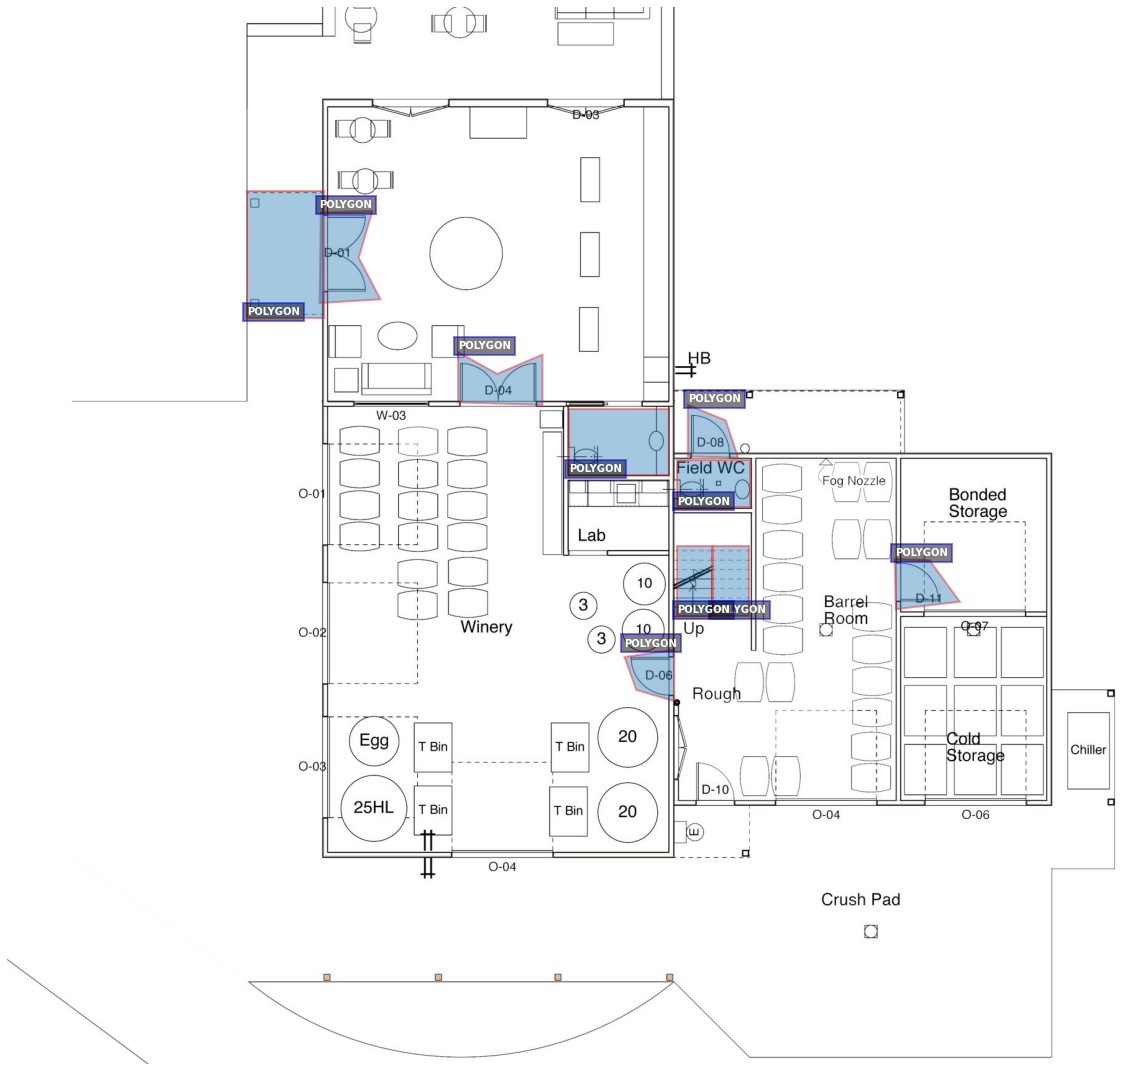

In [16]:
axis = None
main = None

f = plt.figure(figsize=(1,1))

# Creating a Tkinter Window to host the Annotated Image and Annotations
main = create_window("Annotation Validator", "800x600")

# Creating the sidebar which host options and functions for using the annotation validation tool
current_img_dir = create_sidebar(main)

update_canvas(annoImageFilenamesCb.get())

main.mainloop()